In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder

# Financial Fraud Detection

### Dataset Knowledge
The dataset is financial transaction data presumiably from a type of bank. This dataset has already been encoded 

### Features
● Step: A unit of time that represents hours in the dataset. 
● Type: The type of transaction 
● Amount: The amount of money transferred 
● NameOrig: The origin account name
● OldBalanceOrg: The origin accounts balance before the transaction 
● NewBalanceOrg: The origin accounts balance after the transaction 
● NameDest: The destination account name 
● OldbalanceDest: The destination accounts balance before the transaction 
● NewbalanceDest: The destination accounts balance after the transaction 
● IsFlaggedFraud: A “naive” model that simply flags a transaction as fraudulent if it is greater than 200,000.
● IsFraud: Was this simulated transaction actually fraudulent? In this case, we consider “fraud” to be a malicious transaction that aimed to transfer funds out of a victim’s bank account before the account owner could secure their information. 

In [2]:
financials = pd.read_csv("/Users/sa12/Documents/Repositories/FinancialFraudDetection/FraudData/financials.csv", index_col=0)

In [3]:
financials.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6362620 entries, 1 to 743
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 534.0+ MB


These are some ugly column names. gonna change them to something simpiler and maintain specifictiy.

In [4]:
financials.rename(columns={'amount':'Amount','oldbalanceOrg':'OldOrig','newbalanceOrig':'NewOrig','oldbalanceDest':'OldDest','newbalanceDest':'NewDest'}, inplace=True)
financials.head()

,type,Amount,nameOrig,OldOrig,NewOrig,nameDest,OldDest,NewDest,isFraud,isFlaggedFraud
step,,,,,,,,,,
1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [17]:
financials.describe()

,Amount,OldOrig,NewOrig,OldDest,NewDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


### Univariate Analysis

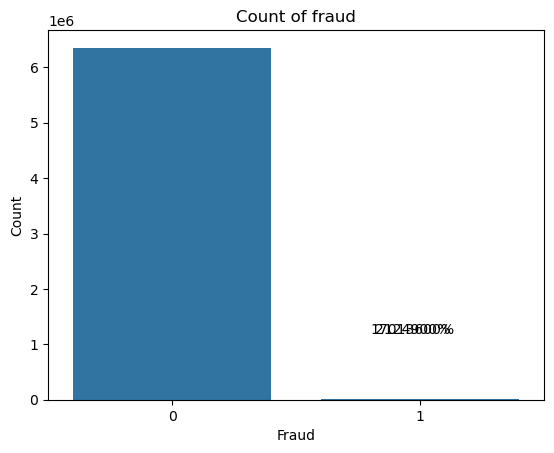

In [51]:
fig = sns.countplot(data=financials, x='isFraud')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.title('Count of fraud')
for i, bar in enumerate(fig.axes.patches):
    height = bar.get_height()
    fig.axes.annotate(
        # reference the pre-calculated row in the dataframe
        f"{financials.iloc[i, 3] :.0%}",
        xytext=(30, 50),
        textcoords="offset points",
        xy=(bar.get_width(), bar.get_y()),
        ha='center', va='center')
plt.show()

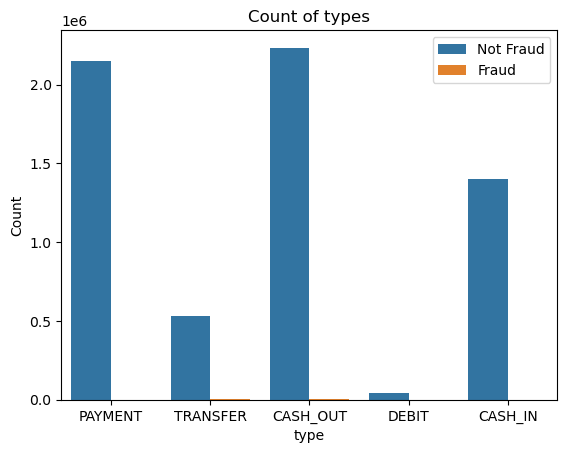

In [55]:
sns.countplot(data=financials, x='type', hue='isFraud')
plt.xlabel('type')
plt.ylabel('Count')
plt.title('Count of types')
plt.legend(['Not Fraud', 'Fraud'])
plt.show()

<Axes: ylabel='type,isFraud'>

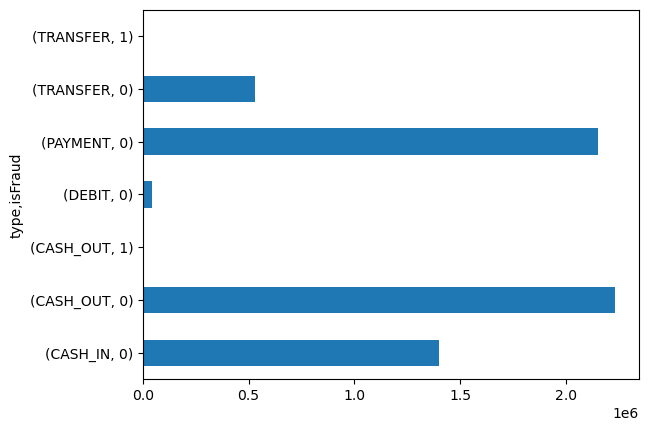

In [7]:
financials.groupby('type')['isFraud'].value_counts().plot(kind='barh')

It seems fraud is localized within the CASH_OUT and TRANSFER types. In order to make our dataset easier to navigate and interperate, seperating out these types could be useful. Creating additional dataframes to contain only fraudulent and non fraudulent data could also be useful.

In [13]:
#creating a dataframe of the CASH_OUT and TRANFER types, encompassing all of our fraud data
tiny_financials = financials[(financials['type'] == 'CASH_OUT') | (financials['type'] == 'TRANSFER')]
#create seperate dataframe with Fraud and Not Fraud exclusively
fraud = financials[financials['isFraud'] == 1]
not_fraud = financials[financials['isFraud'] == 0]
flagged_fraud = financials[financials['isFlaggedFraud'] == 1]

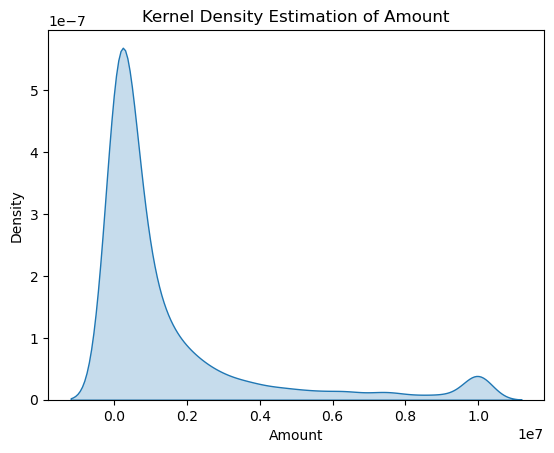

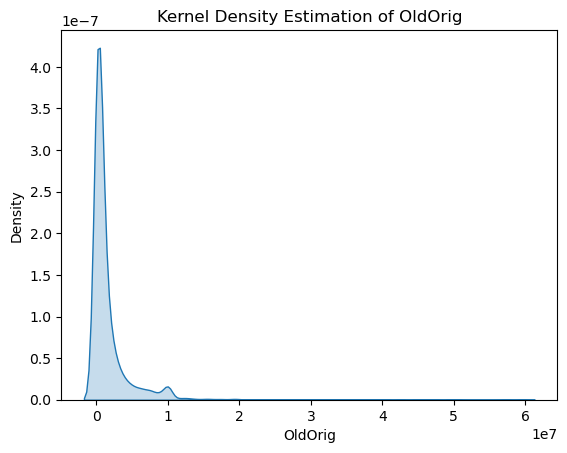

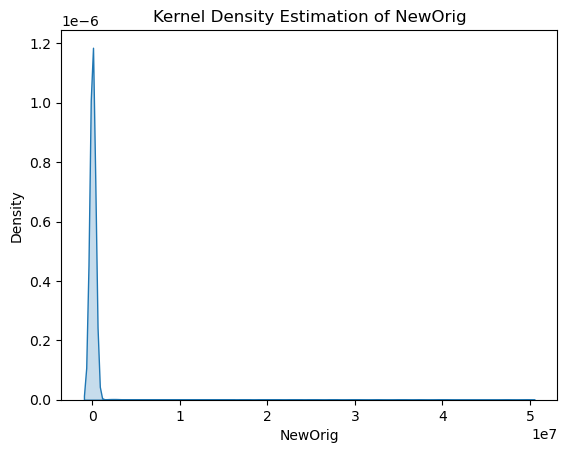

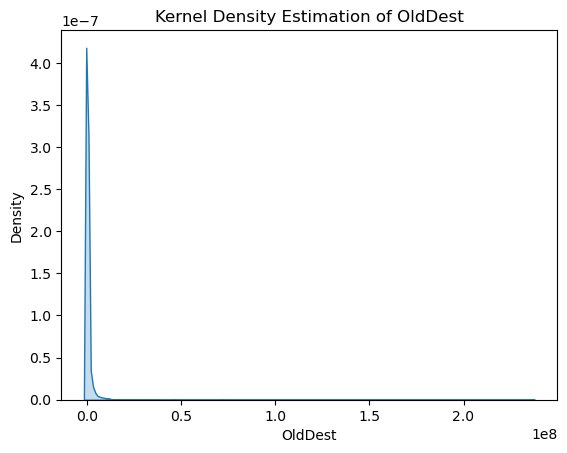

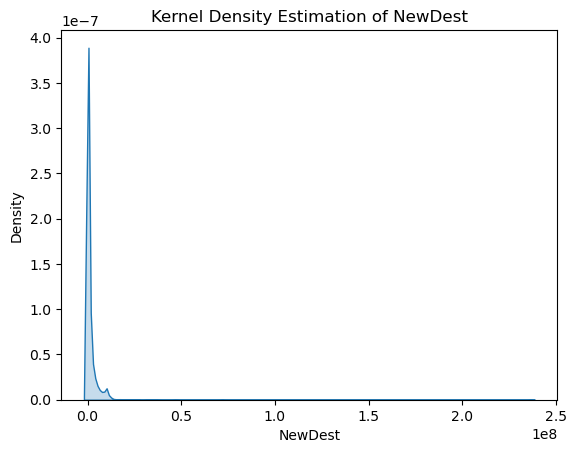

In [28]:
# Iterate over each feature column and plot kde plot
for feature in fraud.columns:
    sns.kdeplot(data=fraud, x=feature, fill=True)
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title(f'Kernel Density Estimation of {feature}')
    plt.show()

All of the data is skew to the right. We also see two large bumps in both amount and OldOrig on the far right of the graph. These may indicate outliers.

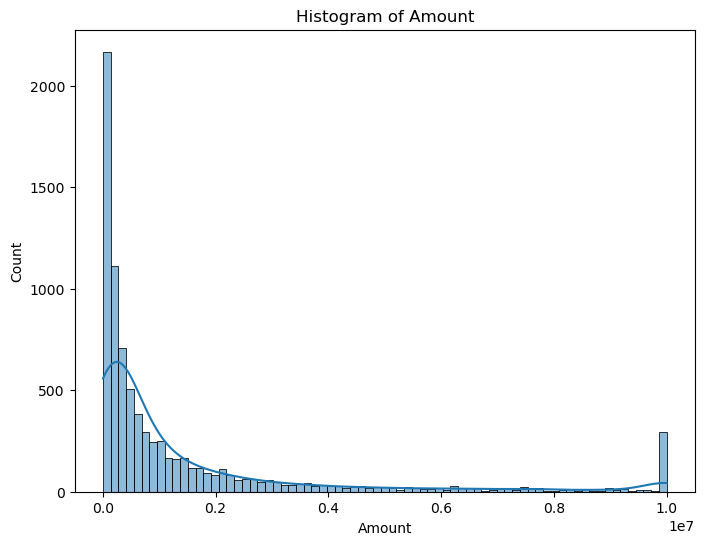

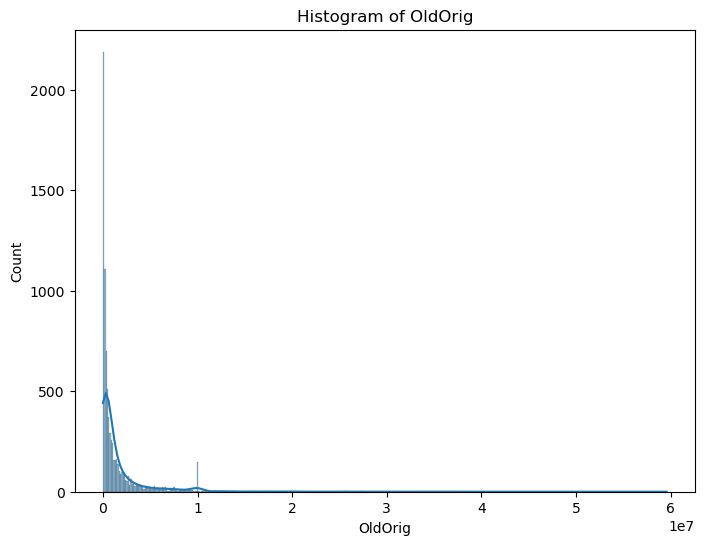

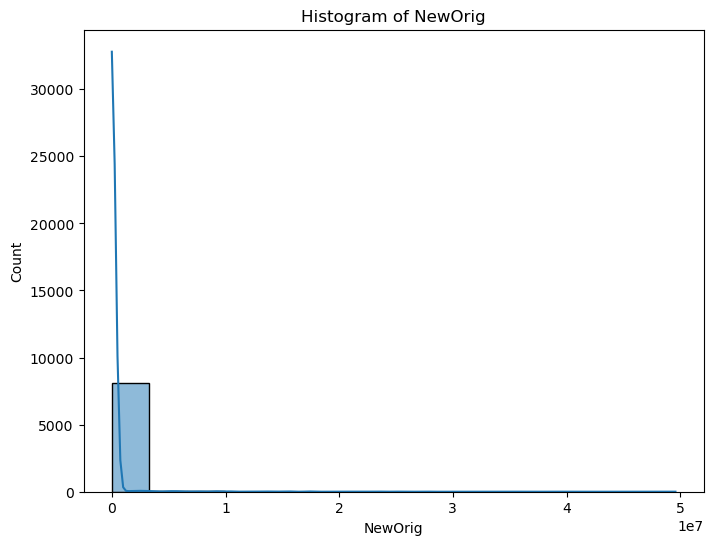

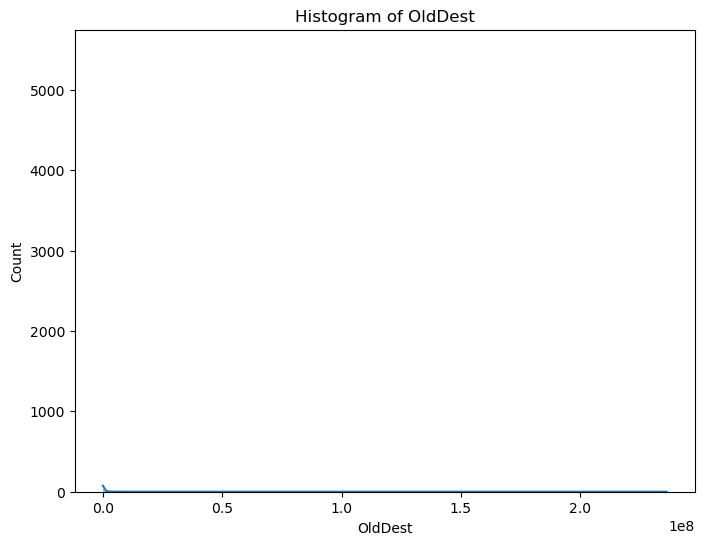

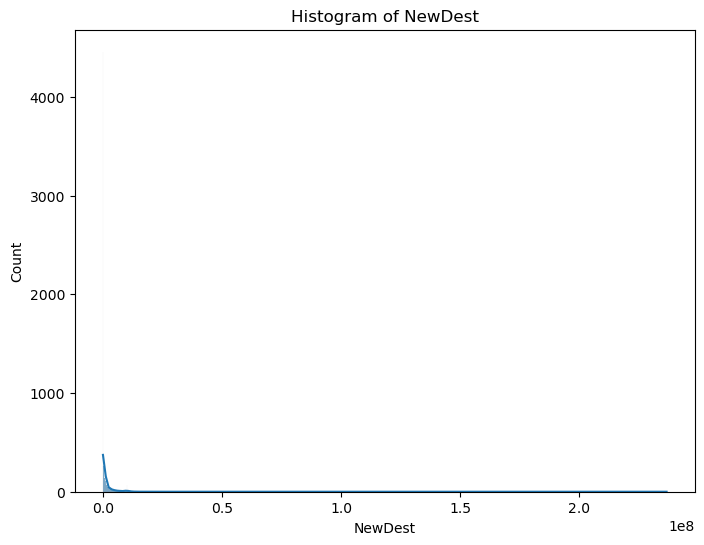

In [29]:
for feature in fraud:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=fraud, x=feature, kde=True)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(f'Histogram of {feature}')
    plt.show()

In [22]:
fraud['Amount'].value_counts()
#there seems to be a collection of values in fraud. Let's compare to non fraud

Amount
10000000.00    287
0.00            16
1165187.89       4
429257.45        4
181.00           2
              ... 
149668.66        1
7316255.05       1
222048.71        1
9585040.37       1
234377.29        1
Name: count, Length: 3977, dtype: int64

In [41]:
not_fraud.sort_values('Amount')
#the value also appears here so it does not seem to be related

,type,Amount,nameOrig,OldOrig,NewOrig,nameDest,OldDest,NewDest,isFraud,isFlaggedFraud
step,,,,,,,,,,
332,CASH_OUT,0.01,C1496340830,0.00,0.00,C554562342,2.627928e+05,2.627928e+05,0,0
233,PAYMENT,0.02,C1371059152,0.00,0.00,M1506318282,0.000000e+00,0.000000e+00,0,0
301,PAYMENT,0.02,C421116740,0.00,0.00,M410442874,0.000000e+00,0.000000e+00,0,0
190,PAYMENT,0.02,C344473063,33192.97,33192.95,M646412904,0.000000e+00,0.000000e+00,0,0
428,PAYMENT,0.03,C1909969960,0.00,0.00,M157485741,0.000000e+00,0.000000e+00,0,0
...,...,...,...,...,...,...,...,...,...,...
284,TRANSFER,69337316.27,C1584456031,0.00,0.00,C1472140329,1.130072e+08,1.823446e+08,0,0
286,TRANSFER,69886731.30,C1425667947,0.00,0.00,C167875008,1.515387e+08,2.214254e+08,0,0
303,TRANSFER,71172480.42,C2044643633,0.00,0.00,C84111522,1.134615e+08,1.846340e+08,0,0


<Axes: xlabel='count', ylabel='Count'>

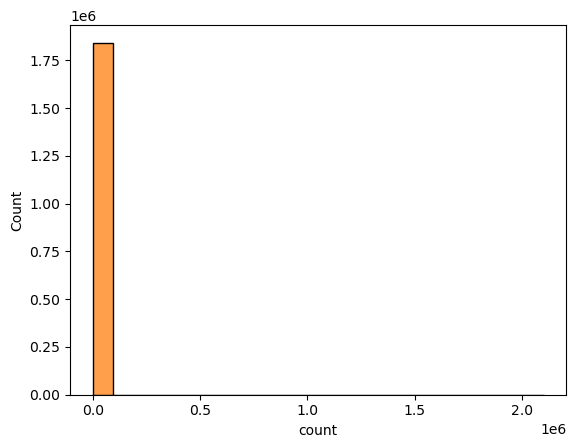

## Bivariate Analysis

There seems to be a large range in numerical columns. I'm going to create a standarized range to so my visualizations can make sense. To begin my bivariate analysis, I'm going to create a pairplot of numerical columns and color them by fraud or not.

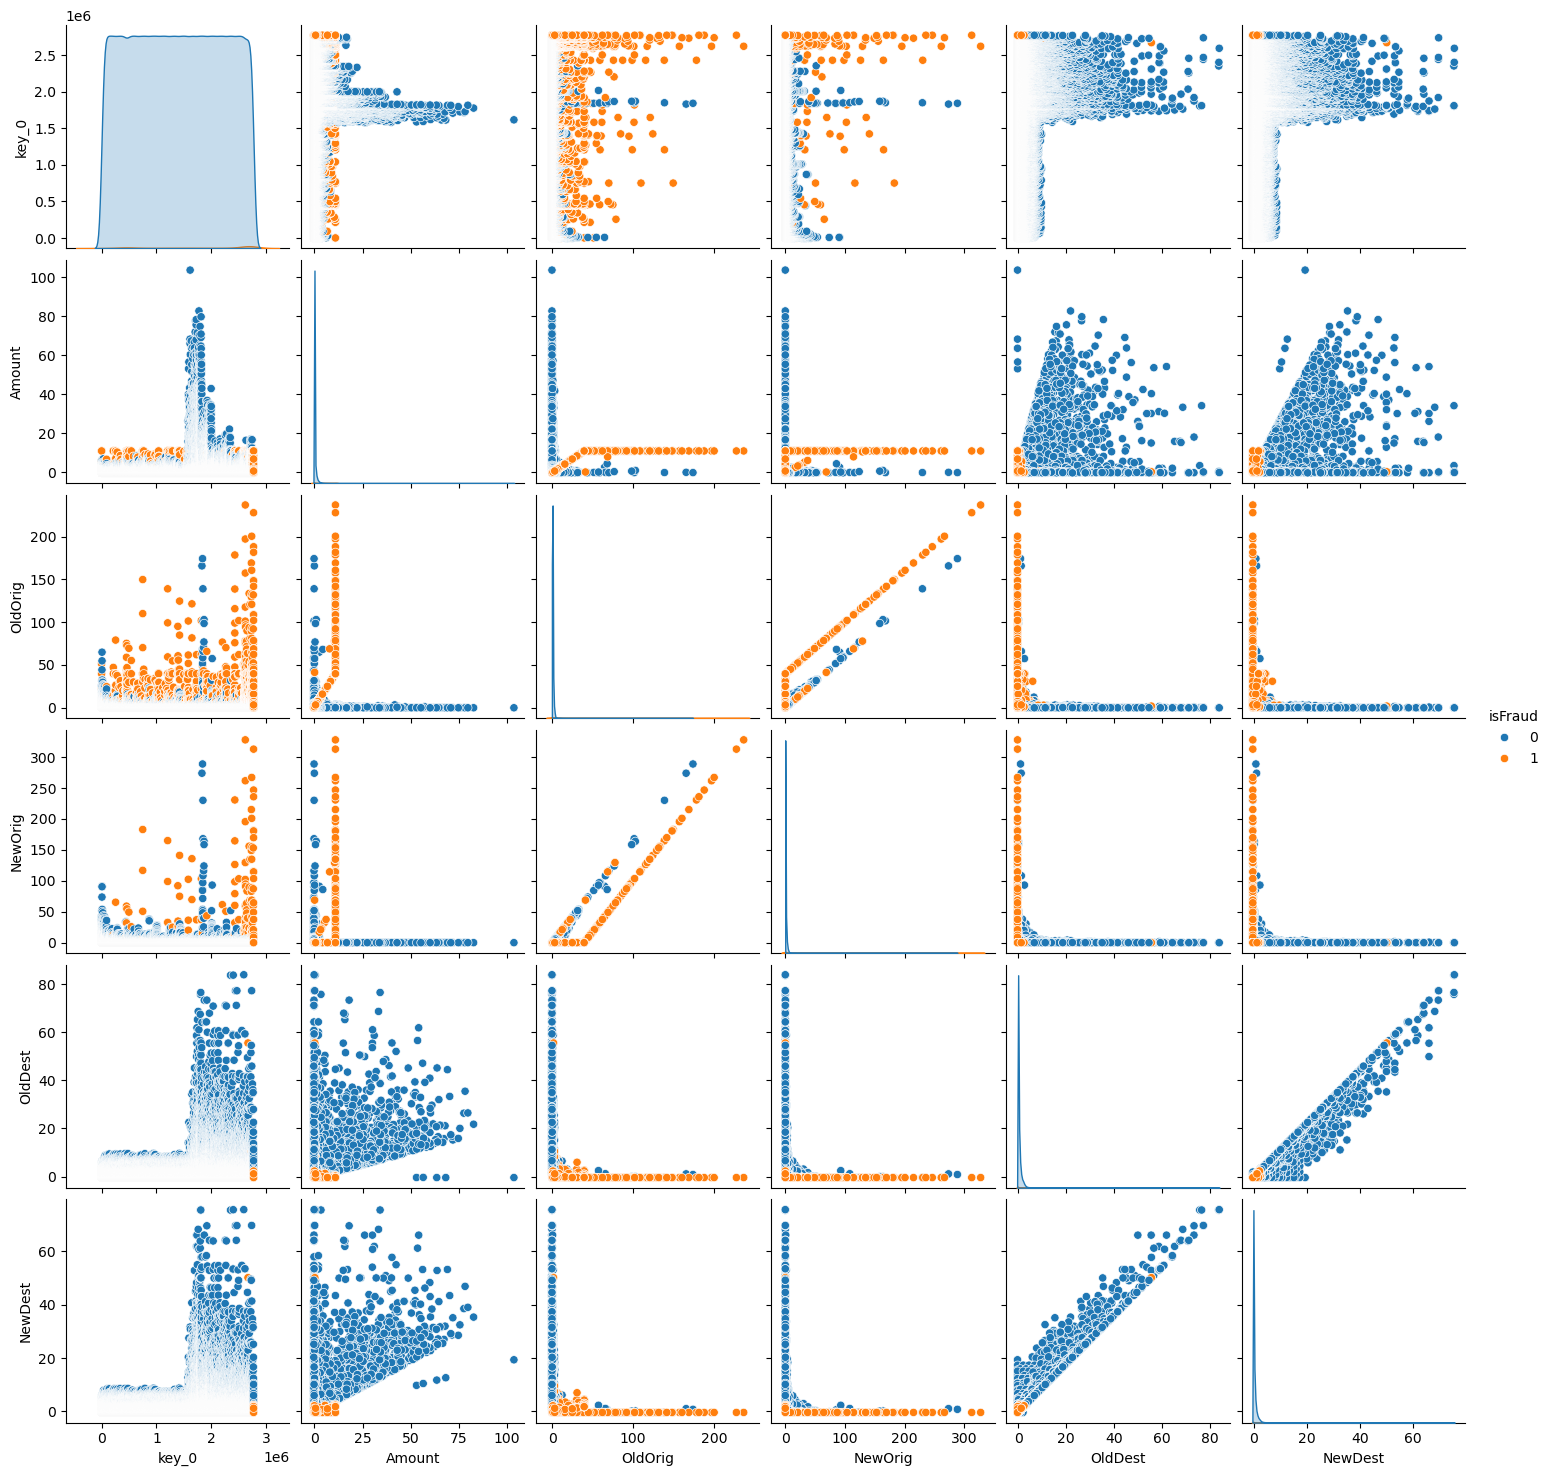

In [11]:
#seperate numerical columns
numerical_columns = ['Amount','OldOrig','NewOrig','OldDest', 'NewDest']
# create a standard scaler object
scaler = StandardScaler()
# Scale the numerical columns
scaled_values = scaler.fit_transform(tiny_financials[numerical_columns])
scaled_financials = pd.DataFrame(scaled_values, columns=(numerical_columns))
#put the isFraud column back to visualize fraud across distributions
scaled_financials = scaled_financials.merge(tiny_financials['isFraud'], how='left', on=scaled_financials.index, right_index=False)
sns.pairplot(scaled_financials, hue='isFraud')
plt.legend(['Not Fraud', 'Fraud'])
plt.show()

There is some vauable information to gained here, specifically by looking at the orange (fraud) values.  
First, it looks like the amount of money in both the old and new destinations is very low in cases of fraud. 
Secondly, the values of the NewDest coulumn seem to be extremly low in cases of fraud when related to both Old and New Orig columns. 
Lastly, there is a linear relationship between both of the Orig columns, as well as the amount column.

I am going to create a heatmap to see correlation in fraud cases.

<Axes: >

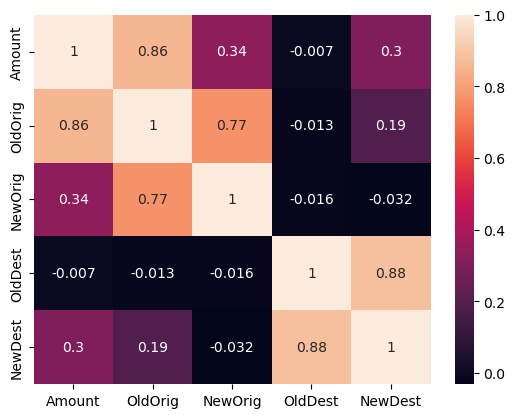

In [15]:
#dropping non-numerical catagories in the fraud dataset.
fraud = fraud.drop(columns=['nameOrig', 'nameDest', 'isFraud','isFlaggedFraud','type'])
#we want to find correlation between the values in fraud so i will create a heatmap
sns.heatmap(fraud.corr(),annot=True)

The OldDest column seems to be the one with the highest correlation amoung fraud cases. The strongest correlation seems to be between the old destination account and the amount tranfered.

<Axes: xlabel='NewDest', ylabel='OldDest'>

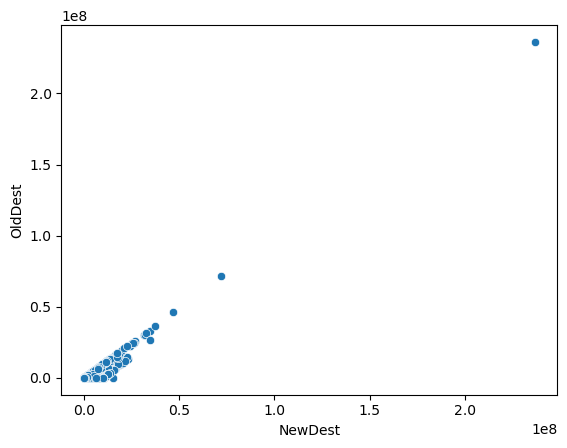

In [44]:
sns.scatterplot(x='NewDest', y='OldDest', data=fraud)

In [42]:
fraud['OldDest'].value_counts()

OldDest
0.00          5351
386985.85        1
716857.20        1
8682013.45       1
6493.14          1
              ... 
388830.36        1
261802.02        1
346223.18        1
85009.83         1
6510099.11       1
Name: count, Length: 2863, dtype: int64

In [43]:
fraud['NewDest'].value_counts()

NewDest
0.00           4091
10000000.00      53
1064995.85        2
127905.82         2
1165187.89        2
               ... 
3098931.52        1
143526.32         1
1532241.85        1
495991.64         1
7360101.63        1
Name: count, Length: 4067, dtype: int64

## Multivariate Analysis